In [1]:
import pandas as pd
import numpy as np
import r2pipe as r2
from tqdm import tqdm

# load dataset
DATASET_PATH = "../dataset/malware_original_x86_64.csv"
DATASET_FOLDER = "/home/mandy900619/data/Malware202403/"
CPU_ARCH = "x86_64"   

print(f"Loading {CPU_ARCH} dataset from {DATASET_PATH}...")
dataset = pd.read_csv(DATASET_PATH)


Loading x86_64 dataset from ../dataset/malware_original_x86_64.csv...


## Dataset Preprocessing

In [2]:
N_WAYS = 15
K_SHOTS = 5
N_GRAM_1 = 2
N_GRAM_2 = 4
NUM_EXAMPLES = 20
NUM_EXAMPLES_TEST = 30
BYTE_LENGTH = 2000
MODEL_NAME = "exp4_optimal"

In [3]:
# extract byte sequences from ELF files
from elftools.elf.elffile import ELFFile
import concurrent.futures

def get_entry_point_byte_sequence(file_path, length=100):
    try:
        with open(file_path, 'rb') as file:
            elffile = ELFFile(file)
            entry_point = elffile.header['e_entry']
            print(f"Entry point: {entry_point}")

            # Find the segment containing the entry point
            for segment in elffile.iter_segments():
                if segment['p_vaddr'] <= entry_point < (segment['p_vaddr'] + segment['p_memsz']):
                    file_offset = entry_point - segment['p_vaddr'] + segment['p_offset']
                    print(f"File offset: {file_offset}")

                    # Seek to the calculated file offset
                    file.seek(file_offset)

                    # Read the specified number of bytes from the file offset
                    byte_sequence = file.read(length)

                    # Convert to hexadecimal representation
                    hex_sequence = byte_sequence.hex()
                    
                    return hex_sequence

            print("Entry point not within any segment.")
            return None

    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None

flag = False

if flag:

    # extract byte sequences

    print(f"Extract byte sequences from {CPU_ARCH} dataset...")
    print(f"Extracting byte sequences of length {BYTE_LENGTH}...")

    for row in tqdm(dataset.itertuples(), total=len(dataset)):
        # open file with r2
        byteAnalysis = r2.open(DATASET_FOLDER + row.file_name[:2] + "/" + row.file_name, flags=["-2"])
        out = byteAnalysis.cmd(f"px* {BYTE_LENGTH}")
        byteAnalysis.cmd("quit")
        lines = out.strip().split("\n")
        byteSeqence = [line[3:-1] for line in lines if not line.startswith("s-")]
        byteSeqence = "".join(byteSeqence)
        dataset.at[row.Index, "byte_sequence"] = byteSeqence
    # def extract_byte_sequence(row):
    #     # 打開文件進行分析
    #     byteAnalysis = r2.open(DATASET_FOLDER + row.file_name[:2] + "/" + row.file_name, flags=["-2"])
    #     out = byteAnalysis.cmd(f"px* {BYTE_LENGTH}")
    #     byteAnalysis.cmd("quit")
    #     lines = out.strip().split("\n")
    #     byteSeqence = [line[3:-1] for line in lines if not line.startswith("s-")]
    #     byteSeqence = "".join(byteSeqence)
    #     print(f'\r{row.Index}', end='')
    #     return row.Index, byteSeqence

    # print(f"Extract byte sequences from {CPU_ARCH} dataset...")
    # print(f"Extracting byte sequences of length {BYTE_LENGTH}...")

    # num_workers = 32

    # with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    #     # 提交任務
    #     futures = {executor.submit(extract_byte_sequence, row): row.Index for row in dataset.itertuples()}
        
    #     for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
    #         index, byteSeqence = future.result()
    #         dataset.at[index, "byte_sequence"] = byteSeqence

    # # 確認平行化處理已完成
    # print("Byte sequence extraction completed.")



In [4]:
# output dataset
if flag:  
    OUTPUT_PATH = f"../dataset/malware_original_{CPU_ARCH}_byte_sequence{BYTE_LENGTH}.csv"
    dataset.to_csv(OUTPUT_PATH, index=False)

In [6]:
# split hex string 
def split_hex_string(hex_string):
    return " ".join([hex_string[i:i+2] for i in range(0, len(hex_string), 2)])

if flag:
    for row in tqdm(dataset.itertuples(), total=len(dataset)):
        dataset.at[row.Index, "byte_sequence"] = split_hex_string(row.byte_sequence)

        OUTPUT_PATH = f"../dataset/malware_original_{CPU_ARCH}_byte_sequence{BYTE_LENGTH}_split.csv"
        dataset.to_csv(OUTPUT_PATH, index=False)

dataset = pd.read_csv(f"../dataset/malware_original_x86_64_byte_sequence{BYTE_LENGTH}_split.csv")


100%|██████████| 122009/122009 [00:23<00:00, 5250.75it/s]


In [8]:
family = dataset['family'].value_counts()[:(N_WAYS)].index
dataset_exp = dataset[dataset['family'].isin(family)]

print(dataset_exp.shape)

# ramdomly select 20 samples for each family
dataset_train = dataset_exp.groupby('family').sample(n=NUM_EXAMPLES, random_state=1)

dataset_test = dataset_exp[~dataset_exp.index.isin(dataset_train.index)].groupby('family').sample(n=NUM_EXAMPLES_TEST, random_state=1)
print(dataset_train.shape)
print(dataset_test.shape)


byteSeqenceTrain = dataset_train['byte_sequence'].values
byteSeqenceTest = dataset_test['byte_sequence'].values
y_train = dataset_train['family'].values
y_test = dataset_test['family'].values


# convert y family to number
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)



(120404, 14)
(300, 14)
(450, 14)


In [11]:
print(len(dataset_test['byte_sequence'].unique()))

315


In [175]:
# extract tf-idf features
from sklearn.feature_extraction.text import TfidfVectorizer
# 4-grams
tfidf_vec = TfidfVectorizer(analyzer='word', ngram_range=(N_GRAM_1, N_GRAM_2), max_features=1000)
tfidf_matrix_train = tfidf_vec.fit_transform(byteSeqenceTrain)
tfidf_matrix_test = tfidf_vec.transform(byteSeqenceTest)

tfidf_matrix_train = tfidf_matrix_train.toarray()
tfidf_matrix_test = tfidf_matrix_test.toarray()

label_mapping = {index: label for index, label in enumerate(le.classes_)}


### Experiment_Prototype Learning_1


In [176]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [177]:
import torch.nn as nn

class ByteSequenceEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(ByteSequenceEmbedding, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size)
        )


    def forward(self, x):
        return self.layers(x)


In [178]:
import torch 
import torch.nn.functional as F
from scipy.spatial import distance

class PrototypeNet(nn.Module):
    def __init__(self, embedding_model):
        super(PrototypeNet, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, support, query, n_way, n_shot, support_labels):
        support_embeddings = self.embedding_model(support)
        query_embeddings = self.embedding_model(query)
        prototypes = support_embeddings.view(n_way, n_shot, -1).mean(dim=1)
        # sort prototype by support_labels order
        unique_labels = []
        for i in range(0, len(support_labels), K_SHOTS):
            unique_labels.append(support_labels[i])
        unique_labels = torch.tensor(unique_labels)
        prototypes = prototypes[torch.argsort(unique_labels)] # random順序 -> label順序(1,2,....,N_WAYS)
        # print(prototypes.shape)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists, prototypes, query_embeddings
    
    def euclidean_distance(self, x, y):
        n = x.size(0)
        m = y.size(0)
        d = x.size(1)
        x = x.unsqueeze(1).expand(n, m, d)
        y = y.unsqueeze(0).expand(n, m, d)
        return torch.pow(x - y, 2).sum(2)



In [179]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

def visualize_embeddings(prototypes, query_embeddings, n_way, n_query, query_labels):
    prototypes_np = prototypes.detach().numpy()
    query_labels = torch.tensor(query_labels)
    query_embeddings_ = query_embeddings[torch.argsort(query_labels)]

    query_embeddings_np = query_embeddings_.detach().numpy()
    


    # Combine prototypes and query embeddings for t-SNE
    combined_embeddings = np.vstack((prototypes_np, query_embeddings_np))
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(combined_embeddings)
    
    # Separate the transformed embeddings
    prototypes_2d = embeddings_2d[:n_way]
    query_embeddings_2d = embeddings_2d[n_way:]

    cmap = plt.get_cmap("tab20", n_way)
    
    # Plotting
    plt.figure(figsize=(14, 8))
    for i in label_mapping.keys():
        plt.scatter(prototypes_2d[i, 0], prototypes_2d[i, 1], marker='X', s=200, color=cmap(i), edgecolors='black', linewidth=0.5, label=f'Prototype {label_mapping[i]}')
        plt.scatter(query_embeddings_2d[i*n_query:(i+1)*n_query, 0], query_embeddings_2d[i*n_query:(i+1)*n_query, 1], color=cmap(i), label=f'Query {label_mapping[i]}')
    
    plt.legend()
    plt.title('t-SNE Visualization of Prototypes and Queries')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [180]:

trainData = tfidf_matrix_train.reshape(N_WAYS, NUM_EXAMPLES, -1)
yData = y_train.reshape(N_WAYS, NUM_EXAMPLES)
print(trainData.shape)
print(yData.shape)



(15, 4, 1000)
(15, 4)


In [181]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler

class ByteSequenceSampler(Sampler):
    def __init__(self, data_source, n_shot = K_SHOTS*2, n_way = N_WAYS, num_examples = NUM_EXAMPLES):
        self.data_source = data_source
        self.n_shot = n_shot
        self.n_way = n_way
        self.num_examples = num_examples
        self.batch_size = n_shot * n_way

    def __iter__(self):

        indices_1 = np.arange(self.data_source.shape[0])
        np.random.shuffle(indices_1)

        indices_2 = np.arange(self.data_source.shape[1])
        np.random.shuffle(indices_2)

        indices = np.array([[i, j] for i in indices_1 for j in indices_2])

        result_indices = []
        for j in range(0, self.num_examples, self.n_shot):        
            for i in range(0, self.n_way):
                result_indices += indices[i * self.num_examples + j: i * self.num_examples + j + self.n_shot].tolist()

        transform = [[[element] for element in row] for row in result_indices]

        for batch in range(0, len(transform), self.batch_size):
            yield transform[batch:batch + self.batch_size]

    
    def __len__(self):
        return len(self.indices) // self.n_shot


In [182]:
from sklearn.metrics import accuracy_score


def train(model, dataloader, n_way, k_shot, num_epoch=10, exp_name="default", save_model=False):
    loss_min = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epoch):
        for i, (data, labels) in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            data = data.squeeze(1)
            support_data, support_labels, query_data, query_labels = split_support_query(data, labels, n_way, k_shot)
            support_data = support_data.float()
            query_data = query_data.float()
            support_labels = support_labels.float()
            query_labels = query_labels.float()
            dists, prototypes, query_embeddings = model(support_data, query_data, n_way, k_shot, support_labels)
            # dists = torch.tensor(dists, requires_grad=True)
            loss = compute_loss(dists, query_labels)
            loss.backward()
            optimizer.step()    
            # for name, param in model.named_parameters():
            #     if param.grad is None:
            #         print(f"No gradient for {name} after epoch {epoch}")
            #     else:
            #         print(f"Gradient for {name} after epoch {epoch}: {param.grad}")
        if save_model:
            if epoch % 10 == 0:
                if loss < loss_min:
                    loss_min = loss
                    torch.save(model.state_dict(), f"./models/model_{exp_name}.pt")
                    print(f"Model saved at epoch {epoch} with loss {loss_min}")
        if epoch % 100 == 0:
            acc = calculate_accuracy(dists, query_labels.view(-1).long(), support_labels.view(-1).long())
            torch.save(model.state_dict(), f"./models/model_{exp_name}_check_point.pt")
            print(f"Epoch {epoch}, Loss {loss.item()}, Accuracy {acc}")



def split_support_query(data, labels, n_way, k_shot):
    support_data = []
    query_data = []
    support_labels = []
    query_labels = []
    
    for i in range(n_way):
        support_data.extend(data[i * 2 * k_shot: i * 2 * k_shot + k_shot])
        query_data.extend(data[i * 2 * k_shot + k_shot: (i + 1) * 2 * k_shot])
        support_labels.extend(labels[i * 2 * k_shot: i * 2 * k_shot + k_shot])
        query_labels.extend(labels[i * 2 * k_shot + k_shot: (i + 1) * 2 * k_shot])
    
    support_data = np.array(support_data)
    query_data = np.array(query_data)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)
    
        
    return torch.tensor(support_data), torch.tensor(support_labels), torch.tensor(query_data), torch.tensor(query_labels)

def calculate_accuracy(dists, query_labels, support_labels):
    preds = torch.argmin(dists, dim=1)
    # print(preds)
    # unique_labels = []
    # for i in range(0, len(support_labels), K_SHOTS):
    #     unique_labels.append(support_labels[i])
    # result_preds = []
    # for label in preds:
    #     index = int(label)
    #     result_preds.append(unique_labels[label])
    # preds = torch.tensor(result_preds)
    acc = accuracy_score(query_labels.cpu().numpy(), preds.cpu().numpy())
    # print(preds)
    # print(labels)
    return acc

def compute_loss(dists, query_labels):
    log_p_y = F.log_softmax(-dists, dim=1).view(N_WAYS, K_SHOTS, -1)
    # print(log_p_y.shape)
    # convert query_labels to int
    query_labels = query_labels.long()
    # convert query_labels to one-hot
    # print(query_labels)
    # query_labels = F.one_hot(query_labels, 15)
    # print(query_labels)
    # print(query_labels.view(15, 5, -1).shape)

    loss_val = -log_p_y.gather(2, query_labels.view(N_WAYS, K_SHOTS, -1)).squeeze().view(-1)
    # print(loss_val)
    loss_val = loss_val.mean()
    # print(loss_val)
    return loss_val


In [183]:
# Train the model


data_tensor = torch.tensor(trainData)
label_tensor = torch.tensor(yData)

trainDataset = TensorDataset(data_tensor, label_tensor)

sampler = ByteSequenceSampler(data_tensor, K_SHOTS*2, N_WAYS, NUM_EXAMPLES) # support + query

trainLoader = DataLoader(trainDataset, batch_sampler=sampler)


embedding_model = ByteSequenceEmbedding(1000, 64, 64)

model = PrototypeNet(embedding_model)

train(model, trainLoader, n_way = N_WAYS, k_shot = K_SHOTS, num_epoch=1000, exp_name=MODEL_NAME, save_model=True)

torch.Size([15, 64])
Model saved at epoch 0 with loss 8.713212966918945
Epoch 0, Loss 8.713212966918945, Accuracy 0.2
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
Model saved at epoch 10 with loss 5.83937931060791
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
Model saved at epoch 20 with loss 3.9717047214508057
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15, 64])
t

In [1]:
# Test the model

def predict(model, support_data, support_labels, query_data, query_labels, n_way, k_shot):
    query_data = torch.tensor(query_data)
    query_labels = torch.tensor(query_labels)
    query_data = query_data.float()
    query_labels = query_labels.float()
    support_data = support_data.float()
    model.eval()
    with torch.no_grad():
        dists, prototypes, query_embeddings = model(support_data, query_data, n_way, k_shot, support_labels)
        dists = torch.tensor(dists)
        acc = calculate_accuracy(dists, query_labels, support_labels.view(-1).long())
    return dists, prototypes, query_embeddings, acc


# get support set
for i, (data, labels) in enumerate(trainLoader):
        data = data.squeeze(1)
        support_data, support_labels, _, _ = split_support_query(data, labels, n_way = N_WAYS, k_shot = K_SHOTS)
        support_data = support_data.float()
        support_labels = support_labels.float()


model.load_state_dict(torch.load(f"./models/model_{MODEL_NAME}.pt"))

dists, prototypes, query_embeddings, acc = predict(model, support_data, support_labels, tfidf_matrix_test, y_test, n_way = N_WAYS, k_shot = K_SHOTS)



NameError: name 'trainLoader' is not defined

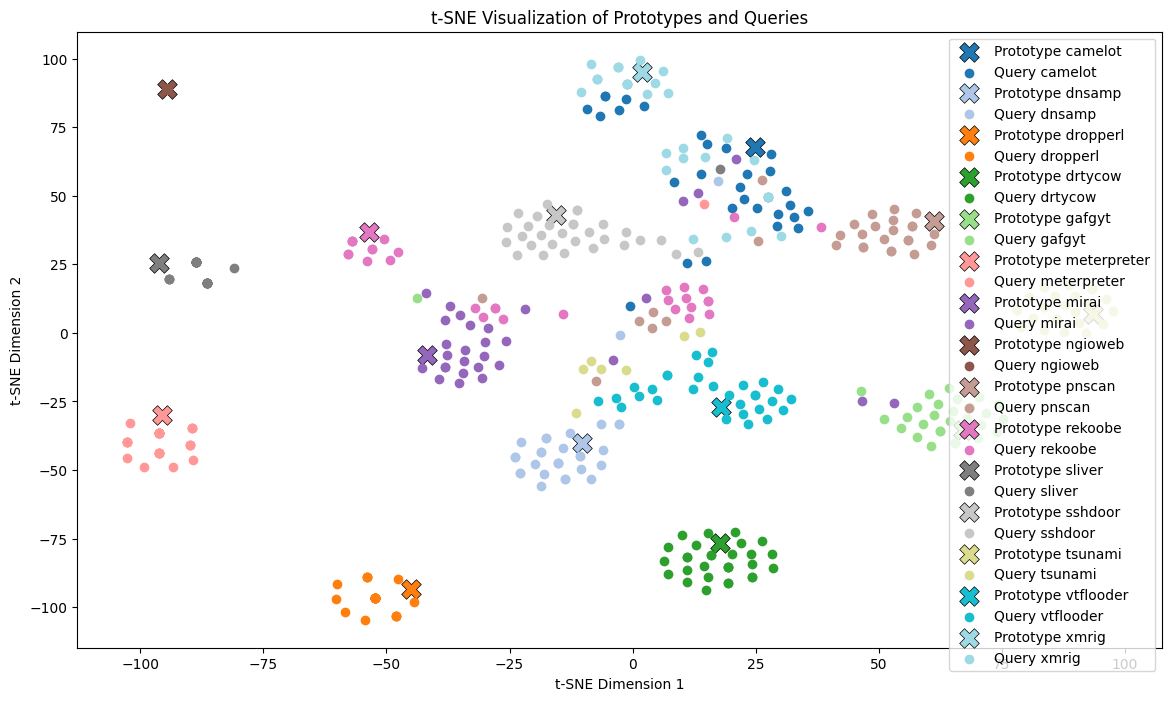

0.8244444444444444


In [186]:


visualize_embeddings(prototypes, query_embeddings, N_WAYS, NUM_EXAMPLES_TEST, query_labels=y_test)

print(acc)

### Experiment_Machine Learning_1

In [83]:
print(f"Training dataset shape: {tfidf_matrix_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Test dataset shape: {tfidf_matrix_test.shape}")
print(f"Labels shape: {y_test.shape}")

Training dataset shape: (150, 1000)
Labels shape: (150,)
Test dataset shape: (450, 1000)
Labels shape: (450,)


In [84]:
# machine learning model
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Shuffle the dataset
tfidf_matrix_train, y_train = shuffle(tfidf_matrix_train, y_train, random_state=1)
tfidf_matrix_test, y_test = shuffle(tfidf_matrix_test, y_test, random_state=1)


svm_classifier = LinearSVC(C=0.2)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
nb_classifier =  MultinomialNB()
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)

svm_classifier.fit(tfidf_matrix_train, y_train)
print("SVM Accuracy:", accuracy_score(y_test, svm_classifier.predict(tfidf_matrix_test)))   

knn_classifier.fit(tfidf_matrix_train, y_train)
print("KNN Accuracy:", accuracy_score(y_test, knn_classifier.predict(tfidf_matrix_test)))

nb_classifier.fit(tfidf_matrix_train, y_train)
print("NB Accuracy:", accuracy_score(y_test, nb_classifier.predict(tfidf_matrix_test)))

mlp_classifier.fit(tfidf_matrix_train, y_train)
print("MLP Accuracy:", accuracy_score(y_test, mlp_classifier.predict(tfidf_matrix_test)))

SVM Accuracy: 0.88
KNN Accuracy: 0.8422222222222222
NB Accuracy: 0.8133333333333334
MLP Accuracy: 0.9111111111111111


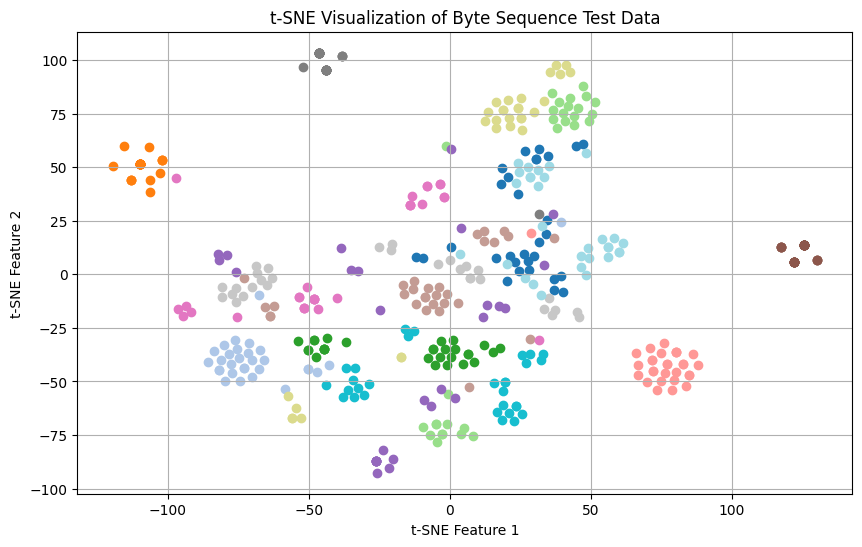

In [76]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tfidf_matrix_test)
# 繪製t-SNE結果
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap("tab20", N_WAYS)
for i in range(N_WAYS):
    plt.scatter(X_tsne[y_test == i, 0], X_tsne[y_test == i, 1], color=cmap(i), label=f'Class {i+1}')


plt.title('t-SNE Visualization of Byte Sequence Test Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.grid(True)
plt.show()